In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path_root = '/data/wumin/dataset/mnist/'

# Reference Papers and Codes
- file:///C:/0STUDY/2022-2023-2/ML/related-papers/Generative%20Adversarial%20Nets.pdf
- file:///C:/0STUDY/2022-2023-2/ML/related-papers/Unsupervised%20Representation%20Learning%20With%20Deep%20Convolutional%20Generative%20Adversarial%20Networks.pdf
- file:///C:/0STUDY/2022-2023-2/ML/ppt/Lect.13a.pdf
- https://browse.arxiv.org/pdf/1606.03657.pdf InfoGAN
- https://browse.arxiv.org/pdf/1610.09585.pdf ACGAN

- https://github.com/znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN/blob/master/pytorch_MNIST_cDCGAN.py#L194
- https://github.com/clvrai/ACGAN-PyTorch/tree/master
- https://github.com/openai/InfoGAN/blob/master/infogan/models/regularized_gan.py
- https://github.com/Natsu6767/InfoGAN-PyTorch/tree/master

- https://blog.csdn.net/u013648063/article/details/105519220 tmux

In [2]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root=data_path_root, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=data_path_root, train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [3]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [4]:
G = torch.load('models/gan_G.pth')
D = torch.load('models/gan_D.pth')

In [6]:
# build network
z_dim = 100
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)

In [ ]:
G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

In [5]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [6]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [8]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
    
    return  D_loss.data.item()

In [9]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
# train_hist['per_epoch_ptimes'] = []
# train_hist['total_ptime'] = []

In [10]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    with torch.no_grad():
        test_z = Variable(torch.randn(bs, z_dim).to(device))
        generated = G(test_z)

        save_image(generated.view(generated.size(0), 1, 28, 28),
                   './samples/gan/sample_epoch_{}.png'.format(num_epoch), nrow=10)

    # test_images = G(fixed_z_)
    # size_figure_grid = 10
    # fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    # for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    #     ax[i, j].get_xaxis().set_visible(False)
    #     ax[i, j].get_yaxis().set_visible(False)

    # for k in range(10*10):
    #     i = k // 10
    #     j = k % 10
    #     ax[i, j].cla()
    #     ax[i, j].imshow(test_images[k].cpu().data.view(28, 28).numpy(), cmap='gray')

    # label = 'Epoch {0}'.format(num_epoch)
    # fig.text(0.5, 0.04, label, ha='center')
    # plt.savefig(path)

    # if show:
    #     plt.show()
    # else:
    #     plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    # display the training losses as epoch increasing
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [11]:
n_epoch = 200
print('training start!')
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.FloatTensor(D_losses).mean(), torch.FloatTensor(G_losses).mean()))
    show_result(epoch)
    
    train_hist['D_losses'].append(torch.FloatTensor(D_losses).mean())
    train_hist['G_losses'].append(torch.FloatTensor(G_losses).mean())

[1/200]: loss_d: 0.815, loss_g: 3.165
[2/200]: loss_d: 0.675, loss_g: 2.814
[3/200]: loss_d: 0.336, loss_g: 4.209
[4/200]: loss_d: 0.396, loss_g: 3.691
[5/200]: loss_d: 0.401, loss_g: 3.563
[6/200]: loss_d: 0.479, loss_g: 3.167
[7/200]: loss_d: 0.475, loss_g: 2.952
[8/200]: loss_d: 0.529, loss_g: 2.743
[9/200]: loss_d: 0.569, loss_g: 2.615
[10/200]: loss_d: 0.570, loss_g: 2.628
[11/200]: loss_d: 0.605, loss_g: 2.508
[12/200]: loss_d: 0.646, loss_g: 2.374
[13/200]: loss_d: 0.656, loss_g: 2.299
[14/200]: loss_d: 0.705, loss_g: 2.272
[15/200]: loss_d: 0.763, loss_g: 2.033
[16/200]: loss_d: 0.794, loss_g: 1.929
[17/200]: loss_d: 0.806, loss_g: 1.850
[18/200]: loss_d: 0.844, loss_g: 1.789
[19/200]: loss_d: 0.871, loss_g: 1.752
[20/200]: loss_d: 0.858, loss_g: 1.726
[21/200]: loss_d: 0.926, loss_g: 1.629
[22/200]: loss_d: 0.896, loss_g: 1.654
[23/200]: loss_d: 0.940, loss_g: 1.552
[24/200]: loss_d: 0.928, loss_g: 1.574
[25/200]: loss_d: 0.959, loss_g: 1.513
[26/200]: loss_d: 0.965, loss_g: 1

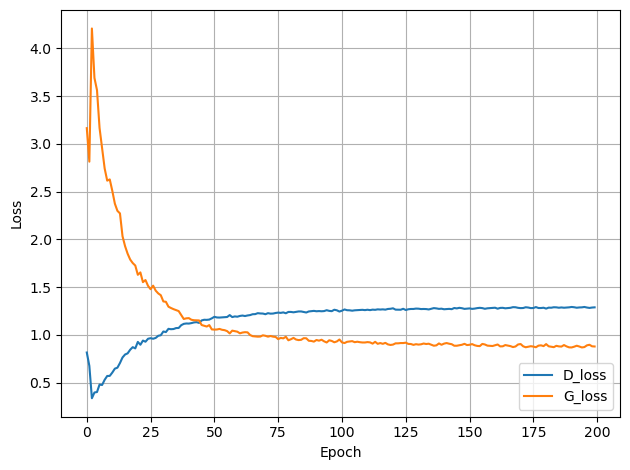

In [39]:
torch.save(G, './models/gan_G.pth')
torch.save(D, './models/gan_D.pth')
show_train_hist(train_hist, True, True, 'samples/gan/history_train_losses.png')

show losses changing in one epoch

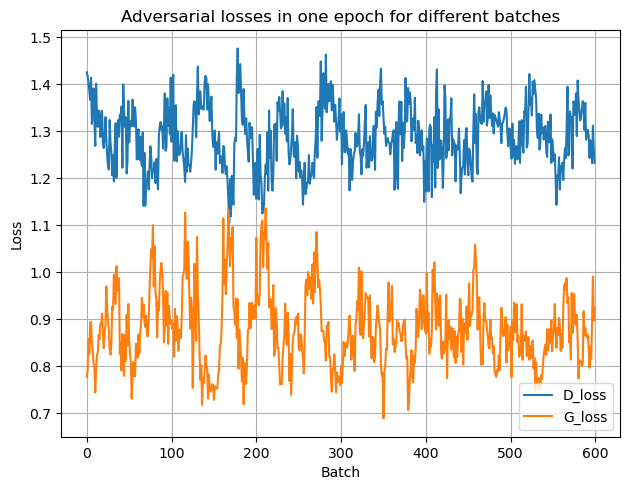

In [38]:
x = range(len(D_losses))
y1 = D_losses
y2 = G_losses

plt.plot(x, y1, label='D_loss')
plt.plot(x, y2, label='G_loss')

plt.xlabel('Batch')
plt.ylabel('Loss')

plt.legend(loc=4)
plt.grid(True)
plt.tight_layout()
plt.title('Adversarial losses in one epoch for different batches')
plt.savefig('samples/gan/adversarial_losses.png')
plt.show()


Generate GIF

In [36]:
images = []
for e in range(n_epoch):
    img_name = 'samples/gan/sample_epoch_' + str(e + 1) + '.png'
    images.append(imageio.v2.imread(img_name))
imageio.mimsave('samples/gan/generation_animation.gif', images, duration=200)

In [15]:
n_epoch = 200
print('training start!')
for epoch in range(201, 201+n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch*2, torch.FloatTensor(D_losses).mean(), torch.FloatTensor(G_losses).mean()))
    show_result(epoch)
    
    train_hist['D_losses'].append(torch.FloatTensor(D_losses).mean())
    train_hist['G_losses'].append(torch.FloatTensor(G_losses).mean())

training start!
[201/400]: loss_d: 1.293, loss_g: 0.868
[202/400]: loss_d: 1.294, loss_g: 0.866
[203/400]: loss_d: 1.288, loss_g: 0.879
[204/400]: loss_d: 1.290, loss_g: 0.874
[205/400]: loss_d: 1.293, loss_g: 0.864
[206/400]: loss_d: 1.294, loss_g: 0.862
[207/400]: loss_d: 1.286, loss_g: 0.879
[208/400]: loss_d: 1.291, loss_g: 0.871
[209/400]: loss_d: 1.292, loss_g: 0.860
[210/400]: loss_d: 1.296, loss_g: 0.865
[211/400]: loss_d: 1.298, loss_g: 0.860
[212/400]: loss_d: 1.292, loss_g: 0.875
[213/400]: loss_d: 1.282, loss_g: 0.885
[214/400]: loss_d: 1.291, loss_g: 0.875
[215/400]: loss_d: 1.289, loss_g: 0.875
[216/400]: loss_d: 1.292, loss_g: 0.865
[217/400]: loss_d: 1.292, loss_g: 0.859
[218/400]: loss_d: 1.292, loss_g: 0.868
[219/400]: loss_d: 1.288, loss_g: 0.878
[220/400]: loss_d: 1.286, loss_g: 0.878
[221/400]: loss_d: 1.291, loss_g: 0.870
[222/400]: loss_d: 1.291, loss_g: 0.873
[223/400]: loss_d: 1.289, loss_g: 0.870
[224/400]: loss_d: 1.288, loss_g: 0.874
[225/400]: loss_d: 1.290

[]